In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/ETFD_Dataset.txt', sep='\t')
df.head()

,blockNumber,confirmations,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,19664511,201879,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,16217669,3648727,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,14351953,5514270,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,19753020,113094,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,19076055,790248,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0


In [4]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')


Shape of Data: (85003, 15)

--- Class Balance (Fraud vs Normal) ---
Fraud
1    0.500029
0    0.499971
Name: proportion, dtype: float64


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_23881/830461818.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')


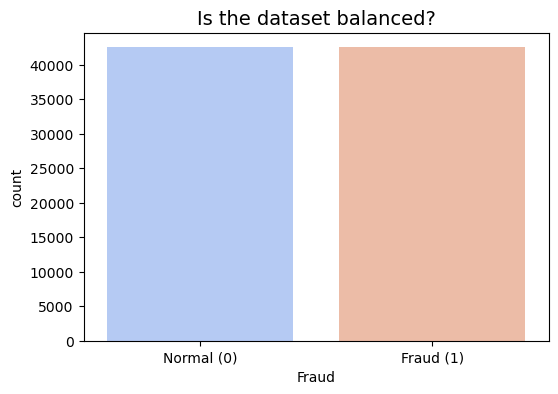


--- Top Features Correlated with Fraud ---
Fraud                                 1.000000
confirmations                         0.880294
total_tx_sent_malicious               0.218554
total_tx_sent_malicious_unique        0.209790
total_tx_received_malicious_unique    0.131387
Month                                 0.097111
Hour                                  0.062414
Day                                  -0.019343
variance_value_received              -0.115796
total_received                       -0.121746
Name: Fraud, dtype: float64
mean_value_received             -0.124467
total_tx_sent_unique            -0.205915
total_tx_sent                   -0.271143
time_diff_first_last_received   -0.376727
blockNumber                     -0.882195
Name: Fraud, dtype: float64


In [7]:
y = df['Fraud']
X = df.drop(columns=['Fraud'])
print(f"\nShape of Data: {df.shape}")

print("\n--- Class Balance (Fraud vs Normal) ---")
print(y.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='coolwarm')
plt.title("Is the dataset balanced?", fontsize=14)
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

corr_matrix = df.select_dtypes(include=[np.number]).corr()
fraud_corr = corr_matrix['Fraud'].sort_values(ascending=False)

print("\n--- Top Features Correlated with Fraud ---")
print(fraud_corr.head(10))
print(fraud_corr.tail(5))